# HW1 1 313511068

## Part 1 N gram

In [67]:
from collections import defaultdict
from tqdm import tqdm
from rich import print
import psutil
import pandas as pd
import matplotlib.pyplot as plt

In [68]:
def display_ram_usage():
    """获取并显示当前的内存使用情况。"""
    ram = psutil.virtual_memory()
    total_ram = ram.total / (1024 ** 3)  # 总内存 (GB)
    used_ram = ram.used / (1024 ** 3)    # 已用内存 (GB)
    percentage_used = ram.percent  # 已用内存百分比
    return total_ram, used_ram, percentage_used

In [69]:

class N_grams:
    def __init__(self,n:int):
        self._n = n + 1
        self._model = defaultdict(lambda: defaultdict(int))
        return 
    
    def _generate_n_grams(self, text:str)->list[str]:
        tokens = list(text.split(" "))
        n_grams = [tokens[i:i+self._n] for i in range(len(tokens) - self._n + 1)]
        return n_grams 
    
    def train(self, corpus_list:list[str]):
        for corpus in tqdm(corpus_list,desc="Training",unit="line"):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:    
                prefix = tuple(ngram[:-1])
                next_word = ngram[-1]
                
                self._model[prefix][next_word] += 1
        return 
    
    def predict(self, prefix:list[str]):
        if tuple(prefix) not in self._model:
            return None
        prefix_key = tuple(prefix)
        next_word = max(self._model[prefix_key], key=self._model[prefix_key].get)
        
        return next_word

    def predict_all(self, prefix:list[str], num:int)-> list[str]:
        res = prefix
        n = self._n - 1
        for _ in range(num):
            res.append(self.predict(res[-n:]))
        
        return res
    
    def test_model(self, corpus_list:list[str] , output_file_name:str)-> dict:
        total_predictions = 0
        correct_predictions = 0
        
        data = {"Acc(%)":[] , "Ram Usage(%)":[]}
        
        # Generate n-grams from test corpus and predict next words
        for corpus in tqdm(corpus_list, desc="Testing",unit="line"):
            ngrams = self._generate_n_grams(corpus)
            
            for ngram in ngrams:
                prefix = ngram[:-1]  # (n-1)-gram前缀
                actual_next_word = ngram[-1]  # 真实的下一个词
                
                predicted_next_word = self.predict(prefix)
                
                if predicted_next_word == actual_next_word:
                    correct_predictions += 1
                
                total_predictions += 1
                
            total_ram, used_ram, percentage_used = display_ram_usage()
            accuracy = correct_predictions / total_predictions if total_predictions > 0 else 0
            # 更新进度条的后缀
            
            data["Ram Usage(%)"].append(percentage_used)
            data["Acc(%)"].append(accuracy * 100)
                

                
        df = pd.DataFrame(data)

        # Step 2: Plot the data using pandas DataFrame's plot method
        ax = df.plot()

        # Step 3: Customize the plot
        ax.set_title(f'{self._n -1} gram memory usage and acc')
        ax.set_xlabel('index')
        ax.set_ylabel('%')
        ax.grid(True)

        # Step 4: Save the plot as an image file
        plt.savefig(output_file_name, dpi=300, bbox_inches='tight')  # Save the figure
        
        # Calculate accuracy
        
        return data

## Load data

In [70]:
with open("./train.txt" , mode="r") as f_train, open("./test.txt", mode="r") as f_test:
    train_data = [line.strip() for line in f_train.readlines()]
    test_data =  [line.strip() for line in f_test.readlines()]
    

## Build model

In [71]:
model_2 = N_grams(2)

In [72]:
model_3 = N_grams(3)

In [73]:
model_2.train(train_data)

Training: 100%|██████████| 2599668/2599668 [00:10<00:00, 239971.82line/s]


In [74]:
model_3.train(train_data)

Training:   0%|          | 0/2599668 [00:00<?, ?line/s]

Training: 100%|██████████| 2599668/2599668 [00:12<00:00, 208881.30line/s]


Testing: 100%|██████████| 649918/649918 [01:41<00:00, 6386.98line/s]


35.71754738420279

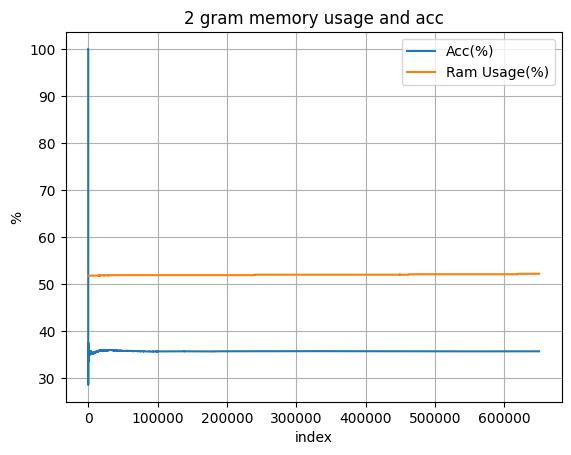

In [9]:
res_2 = model_2.test_model(test_data, output_file_name="res2.png")
print(res_2["Acc(%)"][-1])

Testing: 100%|██████████| 649918/649918 [00:38<00:00, 16666.52line/s]


36.58432955673828

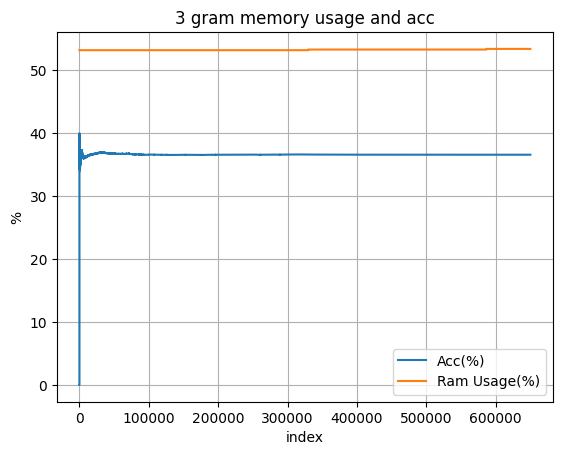

In [10]:
res_3 = model_3.test_model(test_data, output_file_name="res3.png")
print(res_3["Acc(%)"][-1])

## incomplete 

In [75]:
with open("./incomplete.txt", mode="r") as f:
    data = [line.strip() for line in f.readlines()]

In [83]:
res = [model_2.predict_all(item.split(" "), num=20) for item in data]
res = [' '.join(item ) for item in res]
print(res)

[
    'cover with foil and bake for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'roll up and place in a large bowl and mix well and set aside to cool completely on wire rack to cool',
    'cook the pasta and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'stir in the center of the pan and bake for about 5 minutes or until the mixture into the pan and bake',
    'spread out on a baking sheet and bake for about 5 minutes or until the mixture into the pan and bake for',
    'transfer the mixture into the pan and bake for about 5 minutes or until the mixture into the pan and bake 
for',
    'put the chicken and cook for about 5 minutes or until the mixture into the pan and bake for about 5 minutes',
    'push the dough into a large bowl and mix well and set aside to cool completely on wire rack to cool 
completely',
    'cut into squares and serve with a fork and serve with a fork and serve with a fork and serve with a',
    'toss the salad and toss to coat the bottom of the pan and bake for about 5 minutes or until the mixture'
]

## Part 2 RNN

In [20]:
from dataclasses import dataclass
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import lightning as L
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from pytorch_lightning import loggers as pl_loggers
from tqdm import tqdm

In [21]:
@dataclass
class Lib:
    word2idx: dict[str,int]
    idx2word: dict[int,str]
    
    def word_2_index(self, word:str)->int:
        return self.word2idx.get(word, -1)
    
    def index_2_word(self, index:int)->str:
        return self.idx2word.get(index, "")
    
    @classmethod
    def build_from_text(cls, str_list:list[str]):
        group = ' '.join(str_list)
        vocab = set(group.split(" "))
        
        word2idx = {word: i for i,word in enumerate(vocab)}
        idx2word = {idx : word for word, idx in word2idx.items()}
        
        return cls(word2idx, idx2word)
    
    @classmethod
    def build_from_file(cls, filename:str):
        with open(filename, "r") as f:
            data = [item.strip() for item in f.readlines()]
        return cls.build_from_text(data)
    
    def sentence_to_tensor(self, sentence:str):
        return torch.tensor([self.word_2_index(word) for word in sentence.split(" ")], dtype=torch.long)
    
    def tensor_to_sentence(self, tensor:torch.Tensor) ->str:
        return ' '.join([self.index_2_word(int(item)) for item in tensor])

## Build a dataset

In [32]:
class TextDataset(Dataset):
    def __init__(self, sentences:str, n:int, text_lib:Lib):
        self.data = []
        self.n = n 
        
        for sentence in tqdm(sentences, desc="process", unit="line"):
            tensor_line = text_lib.sentence_to_tensor(sentence)
            for i in range(len(tensor_line) - n):
                input_tensor = tensor_line[i:i+n]
                target_tensor = tensor_line[i+n]
                self.data.append((input_tensor, target_tensor))
                
        return 
    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index:int)-> tuple[torch.Tensor,torch.Tensor]:
        return self.data[index]
    
    @classmethod
    def build_from_file(cls, filename:str,n:int, lib: Lib = None):
        with open(file=filename, mode="r") as f:
            data = [line.strip() for line in f.readlines()]
            
        if lib is None:
            lib = Lib.build_from_text(data)
            
        return cls(data, n, lib) 

## RNN Model


In [42]:
class RnnModel(L.LightningModule):
    def __init__(self,vocab_size:int, embedding_dim:int, hidden_size:int, output_size:int, num_layers=1):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
        return 
    
    
    def forward(self, x):
        x = self.embedding(x)
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :]) 
        return out
    
    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        return optimizer
    
    def training_step(self,train_batch, batch_idx):
        
        input_tensor, target_tensor = train_batch
        
        output = self.forward(input_tensor.unsqueeze(0))
        loss = F.cross_entropy(input=output,target=target_tensor)
        self.log('train_loss', loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        
        input_tensor, target_tensor = val_batch
        
        output = self.forward(input_tensor.unsqueeze(0))
        loss = F.cross_entropy(input=output,target=target_tensor)
        self.log("test_loss",  loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return loss

In [43]:
epoch = 10
batch_size = 32
number_of_layer = 2
hidden=128

In [44]:
model = RnnModel(
    vocab_size=2,
    embedding_dim=2,
    hidden_size=hidden,
    output_size=1,
    num_layers=number_of_layer,
)

In [45]:
tb_logger = pl_loggers.TensorBoardLogger("logs/")

In [46]:
trainer = L.Trainer(
    accelerator="gpu",
    logger=tb_logger, 
    default_root_dir="out/", 
    max_epochs=epoch
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [47]:
lib = Lib.build_from_file("./train.txt")

In [48]:
train_dataset = TextDataset.build_from_file("./train.txt",n=2,lib=lib)
test_dataset = TextDataset.build_from_file("./test.txt",n=2,lib=lib)

process: 100%|██████████| 649918/649918 [00:05<00:00, 124805.77line/s]


In [52]:
train_dataset[0]

('pu', 't')

In [49]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [53]:
for i , item in test_dataloader:
    print(item)
    break

('l', 'e', '2', 's', ' ', 'i', 'o', 'r', 'r', 's', ' ', 't', 't', ' ', 'd', 'n', '/', ' ', 't', 'b', 'd', 't', ' ', 'u', 'a', 'e', ' ', 'e', ' ', 'e', 's', 't')


In [50]:
trainer.fit(model, train_dataloader,test_dataloader,ckpt_path="last")

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:186: .fit(ckpt_path="last") is set, but there is no last checkpoint available. No checkpoint will be loaded. HINT: Set `ModelCheckpoint(..., save_last=True)`.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type      | Params | Mode 
------------------------------------------------
0 | embedding | Embedding | 4      | train
1 | rnn       | RNN       | 49.9 K | train
2 | fc        | Linear    | 129    | train
------------------------------------------------
50.1 K    Trainable params
0         Non-trainable params
50.1 K    Total params
0.200     Total estimated model params size (MB)
3         Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.
/home/keithlin/Code/NYCU_LLM_2024/HW1/.venv/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=11` in the `DataLoader` to improve performance.


Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

AttributeError: 'tuple' object has no attribute 'unsqueeze'

In [31]:
# model.train()